# Tokenization
https://en.wikipedia.org/wiki/UTF-8
https://www.youtube.com/watch?v=zduSFxRajkE

The Tokenizer is a necessary and pervasive component of Large Language Models (LLMs), where it translates between strings and tokens (text chunks). Tokenizers are a completely separate stage of the LLM pipeline: they have their own training sets, training algorithms (Byte Pair Encoding), and after training implement two fundamental functions: encode() from strings to tokens, and decode() back from tokens to strings. In this lecture we build from scratch the Tokenizer used in the GPT series from OpenAI. In the process, we will see that a lot of weird behaviors and problems of LLMs actually trace back to tokenization. We'll go through a number of these issues, discuss why tokenization is at fault, and why someone out there ideally finds a way to delete this stage entirely.

## Tokenization is at the heart of much weirdness of LLMs. Do not brush it off.
Tokenization is a process that generate the atoms (fundation ) materails for Transfomer.

* Why can't LLM spell words? Tokenization.
* Why can't LLM do super simple string processing tasks like reversing a string? Tokenization.
* Why is LLM worse at non-English languages (e.g. Japanese)? Tokenization.
* Why is LLM bad at simple arithmetic? Tokenization.
* Why did GPT-2 have more than necessary trouble coding in Python? Tokenization
* Why did my LLM abruptly halt when it sees the string "<|lendoftext|>"? Tokenization
* What is this weird warning l get about a "trailing whitespace"? Tokenization.
* Why the LLM break if i ask it about "SolidGoldMagikarp"? Tokenization. (https://www.lesswrong.com/posts/aPeJE8bSo6rAFoLqg/solidgoldmagikarp-plus-prompt-generation) 
* Why should i prefer to usè YAML over JSON with LLMs? Tokenization. ( YAML is more efficient for tokenization regarding information compression)
* Why is LLM not actually end-to-end language modeling? Tokenization.
* What is the real root of suffering? Tokenization.

https://www.youtube.com/watch?v=zduSFxRajkE 1：51：30 -



# about UTF8 coding

In [1]:
string = "你好，世界" + "hello word"

In [2]:
def simple_encode(string:str, fmt:str='utf-8'):
    return list(string.encode(fmt))

In [3]:
bytes_obj = simple_encode(string)

In [4]:
bytes_obj

[228,
 189,
 160,
 229,
 165,
 189,
 239,
 188,
 140,
 228,
 184,
 150,
 231,
 149,
 140,
 104,
 101,
 108,
 108,
 111,
 32,
 119,
 111,
 114,
 100]

# BPE (Byte Pair Encoding) concept
we can still do raw text encoding by using utf8, but not on character but on text chunk, so reduce the context size.

In [5]:
# https://www.reedbeta.com/blog/programmers-intro-to-unicode/
text = "Ｕｎｉｃｏｄｅ! 🅤🅝🅘🅒🅞🅓🅔‽ 🇺‌🇳‌🇮‌🇨‌🇴‌🇩‌🇪! 😄 The very name strikes fear and awe into the hearts of programmers worldwide. We all know we ought to “support Unicode” in our software (whatever that means—like using wchar_t for all the strings, right?). But Unicode can be abstruse, and diving into the thousand-page Unicode Standard plus its dozens of supplementary annexes, reports, and notes can be more than a little intimidating. I don’t blame programmers for still finding the whole thing mysterious, even 30 years after Unicode’s inception."
# tokens =text.encode("utf-8")# raw bytes
# tokens = list(map(int, tokens))# convert to a list of integers in range 0..255 for convenience
tokens = simple_encode(text)
print('---')
print(text)
print("length:",len(text))
print('---')
print(tokens)
print("length:", len(tokens))

---
Ｕｎｉｃｏｄｅ! 🅤🅝🅘🅒🅞🅓🅔‽ 🇺‌🇳‌🇮‌🇨‌🇴‌🇩‌🇪! 😄 The very name strikes fear and awe into the hearts of programmers worldwide. We all know we ought to “support Unicode” in our software (whatever that means—like using wchar_t for all the strings, right?). But Unicode can be abstruse, and diving into the thousand-page Unicode Standard plus its dozens of supplementary annexes, reports, and notes can be more than a little intimidating. I don’t blame programmers for still finding the whole thing mysterious, even 30 years after Unicode’s inception.
length: 533
---
[239, 188, 181, 239, 189, 142, 239, 189, 137, 239, 189, 131, 239, 189, 143, 239, 189, 132, 239, 189, 133, 33, 32, 240, 159, 133, 164, 240, 159, 133, 157, 240, 159, 133, 152, 240, 159, 133, 146, 240, 159, 133, 158, 240, 159, 133, 147, 240, 159, 133, 148, 226, 128, 189, 32, 240, 159, 135, 186, 226, 128, 140, 240, 159, 135, 179, 226, 128, 140, 240, 159, 135, 174, 226, 128, 140, 240, 159, 135, 168, 226, 128, 140, 240, 159, 135, 180, 226, 128, 140

In [6]:
def get_stats(ids):
    counts ={}
    for pair in zip(ids, ids[1:]): # Pythonic way to iterate consecutive elements
        counts[pair]=counts.get(pair, 0)+1
        
    return counts

stats = get_stats(tokens)  # key(pair of key) : value (count of pair) 
# print(stats)
# print(sorted(((v,k)for k,v in stats.items()),reverse=True))
# (20, (101, 32)) will be the 1st, happen 20 times, i.e. the most freq happen key and value

In [7]:
top_pair = max(stats, key=stats.get)
top_pair

(101, 32)

In [8]:
def merge(ids, pair, idx):
    # in the list of ints (ids), replace all consecutive occurences of pair with the new token idx
    newids = []
    i=0
    while i <len(ids):
        # if we are not at the very last position  (i < len(ids)-1) AND the pair matches, replace it
        if i < len(ids)-1 and ids[i]== pair[0] and ids[i+1]== pair[1]:
            newids.append(idx)
            i += 2
        else:
            newids.append(ids[i])
            i += 1
    return newids

print(merge([5,6,6,7,9,1],(6,7),99)) # replace (6,7) pair with 99 
tokens2 =merge(tokens, top_pair, 256)#print(tokens2)
print("length after one round pair merge:",len(tokens2))

[5, 6, 99, 9, 1]
length after one round pair merge: 596


In [9]:
text = """A Programmer’s Introduction to Unicode
March 3, 2017 · Coding · 25 Comments

Ｕｎｉｃｏｄｅ! 🅤🅝🅘🅒🅞🅓🅔‽ 🇺‌🇳‌🇮‌🇨‌🇴‌🇩‌🇪! 😄 The very name strikes fear and awe into the hearts of programmers worldwide. We all know we ought to “support Unicode” in our software (whatever that means—like using wchar_t for all the strings, right?). But Unicode can be abstruse, and diving into the thousand-page Unicode Standard plus its dozens of supplementary annexes, reports, and notes can be more than a little intimidating. I don’t blame programmers for still finding the whole thing mysterious, even 30 years after Unicode’s inception.

A few months ago, I got interested in Unicode and decided to spend some time learning more about it in detail. In this article, I’ll give an introduction to it from a programmer’s point of view.

I’m going to focus on the character set and what’s involved in working with strings and files of Unicode text. However, in this article I’m not going to talk about fonts, text layout/shaping/rendering, or localization in detail—those are separate issues, beyond my scope (and knowledge) here.

Diversity and Inherent Complexity
The Unicode Codespace
Codespace Allocation
Scripts
Usage Frequency
Encodings
UTF-8
UTF-16
Combining Marks
Canonical Equivalence
Normalization Forms
Grapheme Clusters
And More…
Diversity and Inherent Complexity
As soon as you start to study Unicode, it becomes clear that it represents a large jump in complexity over character sets like ASCII that you may be more familiar with. It’s not just that Unicode contains a much larger number of characters, although that’s part of it. Unicode also has a great deal of internal structure, features, and special cases, making it much more than what one might expect a mere “character set” to be. We’ll see some of that later in this article.

When confronting all this complexity, especially as an engineer, it’s hard not to find oneself asking, “Why do we need all this? Is this really necessary? Couldn’t it be simplified?”

However, Unicode aims to faithfully represent the entire world’s writing systems. The Unicode Consortium’s stated goal is “enabling people around the world to use computers in any language”. And as you might imagine, the diversity of written languages is immense! To date, Unicode supports 135 different scripts, covering some 1100 languages, and there’s still a long tail of over 100 unsupported scripts, both modern and historical, which people are still working to add.

Given this enormous diversity, it’s inevitable that representing it is a complicated project. Unicode embraces that diversity, and accepts the complexity inherent in its mission to include all human writing systems. It doesn’t make a lot of trade-offs in the name of simplification, and it makes exceptions to its own rules where necessary to further its mission.

Moreover, Unicode is committed not just to supporting texts in any single language, but also to letting multiple languages coexist within one text—which introduces even more complexity.

Most programming languages have libraries available to handle the gory low-level details of text manipulation, but as a programmer, you’ll still need to know about certain Unicode features in order to know when and how to apply them. It may take some time to wrap your head around it all, but don’t be discouraged—think about the billions of people for whom your software will be more accessible through supporting text in their language. Embrace the complexity!

The Unicode Codespace
Let’s start with some general orientation. The basic elements of Unicode—its “characters”, although that term isn’t quite right—are called code points. Code points are identified by number, customarily written in hexadecimal with the prefix “U+”, such as U+0041 “A” latin capital letter a or U+03B8 “θ” greek small letter theta. Each code point also has a short name, and quite a few other properties, specified in the Unicode Character Database.

The set of all possible code points is called the codespace. The Unicode codespace consists of 1,114,112 code points. However, only 128,237 of them—about 12% of the codespace—are actually assigned, to date. There’s plenty of room for growth! Unicode also reserves an additional 137,468 code points as “private use” areas, which have no standardized meaning and are available for individual applications to define for their own purposes.

Codespace Allocation
To get a feel for how the codespace is laid out, it’s helpful to visualize it. Below is a map of the entire codespace, with one pixel per code point. It’s arranged in tiles for visual coherence; each small square is 16×16 = 256 code points, and each large square is a “plane” of 65,536 code points. There are 17 planes altogether.

Map of the Unicode codespace (click to zoom)

White represents unassigned space. Blue is assigned code points, green is private-use areas, and the small red area is surrogates (more about those later). As you can see, the assigned code points are distributed somewhat sparsely, but concentrated in the first three planes.

Plane 0 is also known as the “Basic Multilingual Plane”, or BMP. The BMP contains essentially all the characters needed for modern text in any script, including Latin, Cyrillic, Greek, Han (Chinese), Japanese, Korean, Arabic, Hebrew, Devanagari (Indian), and many more.

(In the past, the codespace was just the BMP and no more—Unicode was originally conceived as a straightforward 16-bit encoding, with only 65,536 code points. It was expanded to its current size in 1996. However, the vast majority of code points in modern text belong to the BMP.)

Plane 1 contains historical scripts, such as Sumerian cuneiform and Egyptian hieroglyphs, as well as emoji and various other symbols. Plane 2 contains a large block of less-common and historical Han characters. The remaining planes are empty, except for a small number of rarely-used formatting characters in Plane 14; planes 15–16 are reserved entirely for private use.

Scripts
Let’s zoom in on the first three planes, since that’s where the action is:

Map of scripts in Unicode planes 0–2 (click to zoom)

This map color-codes the 135 different scripts in Unicode. You can see how Han () and Korean () take up most of the range of the BMP (the left large square). By contrast, all of the European, Middle Eastern, and South Asian scripts fit into the first row of the BMP in this diagram.

Many areas of the codespace are adapted or copied from earlier encodings. For example, the first 128 code points of Unicode are just a copy of ASCII. This has clear benefits for compatibility—it’s easy to losslessly convert texts from smaller encodings into Unicode (and the other direction too, as long as no characters outside the smaller encoding are used).

Usage Frequency
One more interesting way to visualize the codespace is to look at the distribution of usage—in other words, how often each code point is actually used in real-world texts. Below is a heat map of planes 0–2 based on a large sample of text from Wikipedia and Twitter (all languages). Frequency increases from black (never seen) through red and yellow to white.

Heat map of code point usage frequency in Unicode planes 0–2 (click to zoom)

You can see that the vast majority of this text sample lies in the BMP, with only scattered usage of code points from planes 1–2. The biggest exception is emoji, which show up here as the several bright squares in the bottom row of plane 1.

Encodings
We’ve seen that Unicode code points are abstractly identified by their index in the codespace, ranging from U+0000 to U+10FFFF. But how do code points get represented as bytes, in memory or in a file?

The most convenient, computer-friendliest (and programmer-friendliest) thing to do would be to just store the code point index as a 32-bit integer. This works, but it consumes 4 bytes per code point, which is sort of a lot. Using 32-bit ints for Unicode will cost you a bunch of extra storage, memory, and performance in bandwidth-bound scenarios, if you work with a lot of text.

Consequently, there are several more-compact encodings for Unicode. The 32-bit integer encoding is officially called UTF-32 (UTF = “Unicode Transformation Format”), but it’s rarely used for storage. At most, it comes up sometimes as a temporary internal representation, for examining or operating on the code points in a string.

Much more commonly, you’ll see Unicode text encoded as either UTF-8 or UTF-16. These are both variable-length encodings, made up of 8-bit or 16-bit units, respectively. In these schemes, code points with smaller index values take up fewer bytes, which saves a lot of memory for typical texts. The trade-off is that processing UTF-8/16 texts is more programmatically involved, and likely slower.

UTF-8
In UTF-8, each code point is stored using 1 to 4 bytes, based on its index value.

UTF-8 uses a system of binary prefixes, in which the high bits of each byte mark whether it’s a single byte, the beginning of a multi-byte sequence, or a continuation byte; the remaining bits, concatenated, give the code point index. This table shows how it works:

UTF-8 (binary)	Code point (binary)	Range
0xxxxxxx	xxxxxxx	U+0000–U+007F
110xxxxx 10yyyyyy	xxxxxyyyyyy	U+0080–U+07FF
1110xxxx 10yyyyyy 10zzzzzz	xxxxyyyyyyzzzzzz	U+0800–U+FFFF
11110xxx 10yyyyyy 10zzzzzz 10wwwwww	xxxyyyyyyzzzzzzwwwwww	U+10000–U+10FFFF
A handy property of UTF-8 is that code points below 128 (ASCII characters) are encoded as single bytes, and all non-ASCII code points are encoded using sequences of bytes 128–255. This has a couple of nice consequences. First, any strings or files out there that are already in ASCII can also be interpreted as UTF-8 without any conversion. Second, lots of widely-used string programming idioms—such as null termination, or delimiters (newlines, tabs, commas, slashes, etc.)—will just work on UTF-8 strings. ASCII bytes never occur inside the encoding of non-ASCII code points, so searching byte-wise for a null terminator or a delimiter will do the right thing.

Thanks to this convenience, it’s relatively simple to extend legacy ASCII programs and APIs to handle UTF-8 strings. UTF-8 is very widely used in the Unix/Linux and Web worlds, and many programmers argue UTF-8 should be the default encoding everywhere.

However, UTF-8 isn’t a drop-in replacement for ASCII strings in all respects. For instance, code that iterates over the “characters” in a string will need to decode UTF-8 and iterate over code points (or maybe grapheme clusters—more about those later), not bytes. When you measure the “length” of a string, you’ll need to think about whether you want the length in bytes, the length in code points, the width of the text when rendered, or something else.

UTF-16
The other encoding that you’re likely to encounter is UTF-16. It uses 16-bit words, with each code point stored as either 1 or 2 words.

Like UTF-8, we can express the UTF-16 encoding rules in the form of binary prefixes:

UTF-16 (binary)	Code point (binary)	Range
xxxxxxxxxxxxxxxx	xxxxxxxxxxxxxxxx	U+0000–U+FFFF
110110xxxxxxxxxx 110111yyyyyyyyyy	xxxxxxxxxxyyyyyyyyyy + 0x10000	U+10000–U+10FFFF
A more common way that people talk about UTF-16 encoding, though, is in terms of code points called “surrogates”. All the code points in the range U+D800–U+DFFF—or in other words, the code points that match the binary prefixes 110110 and 110111 in the table above—are reserved specifically for UTF-16 encoding, and don’t represent any valid characters on their own. They’re only meant to occur in the 2-word encoding pattern above, which is called a “surrogate pair”. Surrogate code points are illegal in any other context! They’re not allowed in UTF-8 or UTF-32 at all.

Historically, UTF-16 is a descendant of the original, pre-1996 versions of Unicode, in which there were only 65,536 code points. The original intention was that there would be no different “encodings”; Unicode was supposed to be a straightforward 16-bit character set. Later, the codespace was expanded to make room for a long tail of less-common (but still important) Han characters, which the Unicode designers didn’t originally plan for. Surrogates were then introduced, as—to put it bluntly—a kludge, allowing 16-bit encodings to access the new code points.

Today, Javascript uses UTF-16 as its standard string representation: if you ask for the length of a string, or iterate over it, etc., the result will be in UTF-16 words, with any code points outside the BMP expressed as surrogate pairs. UTF-16 is also used by the Microsoft Win32 APIs; though Win32 supports either 8-bit or 16-bit strings, the 8-bit version unaccountably still doesn’t support UTF-8—only legacy code-page encodings, like ANSI. This leaves UTF-16 as the only way to get proper Unicode support in Windows. (Update: in Win10 version 1903, they finally added UTF-8 support to the 8-bit APIs! 😊)

By the way, UTF-16’s words can be stored either little-endian or big-endian. Unicode has no opinion on that issue, though it does encourage the convention of putting U+FEFF zero width no-break space at the top of a UTF-16 file as a byte-order mark, to disambiguate the endianness. (If the file doesn’t match the system’s endianness, the BOM will be decoded as U+FFFE, which isn’t a valid code point.)

Combining Marks
In the story so far, we’ve been focusing on code points. But in Unicode, a “character” can be more complicated than just an individual code point!

Unicode includes a system for dynamically composing characters, by combining multiple code points together. This is used in various ways to gain flexibility without causing a huge combinatorial explosion in the number of code points.

In European languages, for example, this shows up in the application of diacritics to letters. Unicode supports a wide range of diacritics, including acute and grave accents, umlauts, cedillas, and many more. All these diacritics can be applied to any letter of any alphabet—and in fact, multiple diacritics can be used on a single letter.

If Unicode tried to assign a distinct code point to every possible combination of letter and diacritics, things would rapidly get out of hand. Instead, the dynamic composition system enables you to construct the character you want, by starting with a base code point (the letter) and appending additional code points, called “combining marks”, to specify the diacritics. When a text renderer sees a sequence like this in a string, it automatically stacks the diacritics over or under the base letter to create a composed character.

For example, the accented character “Á” can be expressed as a string of two code points: U+0041 “A” latin capital letter a plus U+0301 “◌́” combining acute accent. This string automatically gets rendered as a single character: “Á”.

Now, Unicode does also include many “precomposed” code points, each representing a letter with some combination of diacritics already applied, such as U+00C1 “Á” latin capital letter a with acute or U+1EC7 “ệ” latin small letter e with circumflex and dot below. I suspect these are mostly inherited from older encodings that were assimilated into Unicode, and kept around for compatibility. In practice, there are precomposed code points for most of the common letter-with-diacritic combinations in European-script languages, so they don’t use dynamic composition that much in typical text.

Still, the system of combining marks does allow for an arbitrary number of diacritics to be stacked on any base character. The reductio-ad-absurdum of this is Zalgo text, which works by ͖͟ͅr͞aṋ̫̠̖͈̗d͖̻̹óm̪͙͕̗̝ļ͇̰͓̳̫ý͓̥̟͍ ̕s̫t̫̱͕̗̰̼̘͜a̼̩͖͇̠͈̣͝c̙͍k̖̱̹͍͘i̢n̨̺̝͇͇̟͙ģ̫̮͎̻̟ͅ ̕n̼̺͈͞u̮͙m̺̭̟̗͞e̞͓̰̤͓̫r̵o̖ṷs҉̪͍̭̬̝̤ ̮͉̝̞̗̟͠d̴̟̜̱͕͚i͇̫̼̯̭̜͡ḁ͙̻̼c̲̲̹r̨̠̹̣̰̦i̱t̤̻̤͍͙̘̕i̵̜̭̤̱͎c̵s ͘o̱̲͈̙͖͇̲͢n͘ ̜͈e̬̲̠̩ac͕̺̠͉h̷̪ ̺̣͖̱ḻ̫̬̝̹ḙ̙̺͙̭͓̲t̞̞͇̲͉͍t̷͔̪͉̲̻̠͙e̦̻͈͉͇r͇̭̭̬͖,̖́ ̜͙͓̣̭s̘̘͈o̱̰̤̲ͅ ̛̬̜̙t̼̦͕̱̹͕̥h̳̲͈͝ͅa̦t̻̲ ̻̟̭̦̖t̛̰̩h̠͕̳̝̫͕e͈̤̘͖̞͘y҉̝͙ ̷͉͔̰̠o̞̰v͈͈̳̘͜er̶f̰͈͔ḻ͕̘̫̺̲o̲̭͙͠ͅw̱̳̺ ͜t̸h͇̭͕̳͍e̖̯̟̠ ͍̞̜͔̩̪͜ļ͎̪̲͚i̝̲̹̙̩̹n̨̦̩̖ḙ̼̲̼͢ͅ ̬͝s̼͚̘̞͝p͙̘̻a̙c҉͉̜̤͈̯̖i̥͡n̦̠̱͟g̸̗̻̦̭̮̟ͅ ̳̪̠͖̳̯̕a̫͜n͝d͡ ̣̦̙ͅc̪̗r̴͙̮̦̹̳e͇͚̞͔̹̫͟a̙̺̙ț͔͎̘̹ͅe̥̩͍ a͖̪̜̮͙̹n̢͉̝ ͇͉͓̦̼́a̳͖̪̤̱p̖͔͔̟͇͎͠p̱͍̺ę̲͎͈̰̲̤̫a̯͜r̨̮̫̣̘a̩̯͖n̹̦̰͎̣̞̞c̨̦̱͔͎͍͖e̬͓͘ ̤̰̩͙̤̬͙o̵̼̻̬̻͇̮̪f̴ ̡̙̭͓͖̪̤“̸͙̠̼c̳̗͜o͏̼͙͔̮r̞̫̺̞̥̬ru̺̻̯͉̭̻̯p̰̥͓̣̫̙̤͢t̳͍̳̖ͅi̶͈̝͙̼̙̹o̡͔n̙̺̹̖̩͝ͅ”̨̗͖͚̩.̯͓

A few other places where dynamic character composition shows up in Unicode:
Vowel-pointing notation in Arabic and Hebrew. In these languages, words are normally spelled with some of their vowels left out. They then have diacritic notation to indicate the vowels (used in dictionaries, language-teaching materials, children’s books, and such). These diacritics are expressed with combining marks.

A Hebrew example, with niqqud:	אֶת דַלְתִּי הֵזִיז הֵנִיעַ, קֶטֶב לִשְׁכַּתִּי יָשׁוֹד
Normal writing (no niqqud):	את דלתי הזיז הניע, קטב לשכתי ישוד
Devanagari, the script used to write Hindi, Sanskrit, and many other South Asian languages, expresses certain vowels as combining marks attached to consonant letters. For example, “ह” + “​ि” = “हि” (“h” + “i” = “hi”).

Korean characters stand for syllables, but they are composed of letters called jamo that stand for the vowels and consonants in the syllable. While there are code points for precomposed Korean syllables, it’s also possible to dynamically compose them by concatenating their jamo. For example, “ᄒ” + “ᅡ” + “ᆫ” = “한” (“h” + “a” + “n” = “han”).

Canonical Equivalence
In Unicode, precomposed characters exist alongside the dynamic composition system. A consequence of this is that there are multiple ways to express “the same” string—different sequences of code points that result in the same user-perceived characters. For example, as we saw earlier, we can express the character “Á” either as the single code point U+00C1, or as the string of two code points U+0041 U+0301.

Another source of ambiguity is the ordering of multiple diacritics in a single character. Diacritic order matters visually when two diacritics apply to the same side of the base character, e.g. both above: “ǡ” (dot, then macron) is different from “ā̇” (macron, then dot). However, when diacritics apply to different sides of the character, e.g. one above and one below, then the order doesn’t affect rendering. Moreover, a character with multiple diacritics might have one of the diacritics precomposed and others expressed as combining marks.

For example, the Vietnamese letter “ệ” can be expressed in five different ways:

Fully precomposed: U+1EC7 “ệ”
Partially precomposed: U+1EB9 “ẹ” + U+0302 “◌̂”
Partially precomposed: U+00EA “ê” + U+0323 “◌̣”
Fully decomposed: U+0065 “e” + U+0323 “◌̣” + U+0302 “◌̂”
Fully decomposed: U+0065 “e” + U+0302 “◌̂” + U+0323 “◌̣”
Unicode refers to set of strings like this as “canonically equivalent”. Canonically equivalent strings are supposed to be treated as identical for purposes of searching, sorting, rendering, text selection, and so on. This has implications for how you implement operations on text. For example, if an app has a “find in file” operation and the user searches for “ệ”, it should, by default, find occurrences of any of the five versions of “ệ” above!

Normalization Forms
To address the problem of “how to handle canonically equivalent strings”, Unicode defines several normalization forms: ways of converting strings into a canonical form so that they can be compared code-point-by-code-point (or byte-by-byte).

The “NFD” normalization form fully decomposes every character down to its component base and combining marks, taking apart any precomposed code points in the string. It also sorts the combining marks in each character according to their rendered position, so e.g. diacritics that go below the character come before the ones that go above the character. (It doesn’t reorder diacritics in the same rendered position, since their order matters visually, as previously mentioned.)

The “NFC” form, conversely, puts things back together into precomposed code points as much as possible. If an unusual combination of diacritics is called for, there may not be any precomposed code point for it, in which case NFC still precomposes what it can and leaves any remaining combining marks in place (again ordered by rendered position, as in NFD).

There are also forms called NFKD and NFKC. The “K” here refers to compatibility decompositions, which cover characters that are “similar” in some sense but not visually identical. However, I’m not going to cover that here.

Grapheme Clusters
As we’ve seen, Unicode contains various cases where a thing that a user thinks of as a single “character” might actually be made up of multiple code points under the hood. Unicode formalizes this using the notion of a grapheme cluster: a string of one or more code points that constitute a single “user-perceived character”.

UAX #29 defines the rules for what, precisely, qualifies as a grapheme cluster. It’s approximately “a base code point followed by any number of combining marks”, but the actual definition is a bit more complicated; it accounts for things like Korean jamo, and emoji ZWJ sequences.

The main thing grapheme clusters are used for is text editing: they’re often the most sensible unit for cursor placement and text selection boundaries. Using grapheme clusters for these purposes ensures that you can’t accidentally chop off some diacritics when you copy-and-paste text, that left/right arrow keys always move the cursor by one visible character, and so on.

Another place where grapheme clusters are useful is in enforcing a string length limit—say, on a database field. While the true, underlying limit might be something like the byte length of the string in UTF-8, you wouldn’t want to enforce that by just truncating bytes. At a minimum, you’d want to “round down” to the nearest code point boundary; but even better, round down to the nearest grapheme cluster boundary. Otherwise, you might be corrupting the last character by cutting off a diacritic, or interrupting a jamo sequence or ZWJ sequence.

And More…
There’s much more that could be said about Unicode from a programmer’s perspective! I haven’t gotten into such fun topics as case mapping, collation, compatibility decompositions and confusables, Unicode-aware regexes, or bidirectional text. Nor have I said anything yet about implementation issues—how to efficiently store and look-up data about the sparsely-assigned code points, or how to optimize UTF-8 decoding, string comparison, or NFC normalization. Perhaps I’ll return to some of those things in future posts.

Unicode is a fascinating and complex system. It has a many-to-one mapping between bytes and code points, and on top of that a many-to-one (or, under some circumstances, many-to-many) mapping between code points and “characters”. It has oddball special cases in every corner. But no one ever claimed that representing all written languages was going to be easy, and it’s clear that we’re never going back to the bad old days of a patchwork of incompatible encodings.

Further reading:

The Unicode Standard
UTF-8 Everywhere Manifesto
Dark corners of Unicode by Eevee
ICU (International Components for Unicode)—C/C++/Java libraries implementing many Unicode algorithms and related things
Python 3 Unicode Howto
Google Noto Fonts—set of fonts intended to cover all assigned code points
"""
tokens = simple_encode(text)

In [10]:
# vocab_size=276 # the desired final vocabulary size

# num_merges=vocab_size-256 # total merge iteration times
# ids = list(tokens)# copy so we don't destroy the original list

# # a k-v list for recording all (int,int)->int mapping
# merges ={}#(int,int)->int

# for i in range(num_merges):
#     stats = get_stats(ids)
#     pair = max(stats, key=stats.get)
#     idx=256 + i
#     print(f"merging {pair} into a new token {idx}")
#     ids = merge(ids, pair, idx)
#     merges[pair]= idx

# print("tokens length:",len(tokens))
# print("ids length:",len(ids))
# print(f"compression ratio:{len(tokens)/ len(ids):.2f}X")
# print(merges)

In [11]:
def iter_merge(tokens_to_process, vocab_size):
    '''multiple rounds merge, rounds controlled by vocab_size (must be >=256) 
       each round merge, map one (int,int) pair to one int
       return merged token list, as well as merges dict
    '''
    num_merges=vocab_size-256 # total merge iteration times
    
    merged = list(tokens_to_process)# copy so we don't destroy the original list
    # a k-v list for recording all (int,int)->int mapping
    merges ={}#(int,int)->int
    
    for i in range(num_merges):
        stats = get_stats(merged)
        pair = max(stats, key=stats.get)
        idx=256 + i
        merged = merge(merged, pair, idx)
        print(f"merging {pair} into a new token {idx}")
        merges[pair]= idx
    
    print("tokens length before merge:",len(tokens_to_process))
    print("tokens length after  merge:",len(merged))
    print(f"compression ratio:{len(tokens_to_process)/ len(merged):.2f}X, after {num_merges} rounds compression")

    return merged, merges
    

In [12]:
tokens = simple_encode(text)
merged, merges = iter_merge(tokens, 276)
print(merges)

merging (101, 32) into a new token 256
merging (105, 110) into a new token 257
merging (115, 32) into a new token 258
merging (116, 104) into a new token 259
merging (101, 114) into a new token 260
merging (99, 111) into a new token 261
merging (116, 32) into a new token 262
merging (226, 128) into a new token 263
merging (44, 32) into a new token 264
merging (97, 110) into a new token 265
merging (111, 114) into a new token 266
merging (100, 32) into a new token 267
merging (97, 114) into a new token 268
merging (101, 110) into a new token 269
merging (257, 103) into a new token 270
merging (261, 100) into a new token 271
merging (121, 32) into a new token 272
merging (97, 108) into a new token 273
merging (259, 256) into a new token 274
merging (111, 110) into a new token 275
tokens length before merge: 24613
tokens length after  merge: 19489
compression ratio:1.26X, after 20 rounds compression
{(101, 32): 256, (105, 110): 257, (115, 32): 258, (116, 104): 259, (101, 114): 260, (99, 1

Note , the Tokenizer is a completely separate , independent module from the LLM . It has its own training dataset of text ( which could be different from that of the LLM ), on which you train the vocabulary using the Byte Pair Encoding ( BPE ) algorithm . It then translates back and forth between raw text and sequences of tokens . The LLM later only ever sees the tokens and never directly deals with any text .

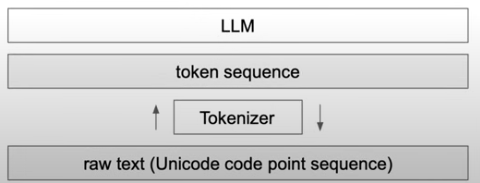

# decode
Given a sequence of integers in the range [0, vocab _size], what is the text?

In [13]:
# vocab: the 
# generate unicode byte sequence from 0x0 -> 0xff
vocab ={idx: bytes([idx])for idx in range(256)}
# print(vocab)

#from merges grab and add merges pair into 
for(p0,p1),idx in merges.items():
    vocab[idx]=vocab[p0]+vocab[p1]  #将两个字节序列连接在一起,combine to a new byte sequence

print(vocab)

{0: b'\x00', 1: b'\x01', 2: b'\x02', 3: b'\x03', 4: b'\x04', 5: b'\x05', 6: b'\x06', 7: b'\x07', 8: b'\x08', 9: b'\t', 10: b'\n', 11: b'\x0b', 12: b'\x0c', 13: b'\r', 14: b'\x0e', 15: b'\x0f', 16: b'\x10', 17: b'\x11', 18: b'\x12', 19: b'\x13', 20: b'\x14', 21: b'\x15', 22: b'\x16', 23: b'\x17', 24: b'\x18', 25: b'\x19', 26: b'\x1a', 27: b'\x1b', 28: b'\x1c', 29: b'\x1d', 30: b'\x1e', 31: b'\x1f', 32: b' ', 33: b'!', 34: b'"', 35: b'#', 36: b'$', 37: b'%', 38: b'&', 39: b"'", 40: b'(', 41: b')', 42: b'*', 43: b'+', 44: b',', 45: b'-', 46: b'.', 47: b'/', 48: b'0', 49: b'1', 50: b'2', 51: b'3', 52: b'4', 53: b'5', 54: b'6', 55: b'7', 56: b'8', 57: b'9', 58: b':', 59: b';', 60: b'<', 61: b'=', 62: b'>', 63: b'?', 64: b'@', 65: b'A', 66: b'B', 67: b'C', 68: b'D', 69: b'E', 70: b'F', 71: b'G', 72: b'H', 73: b'I', 74: b'J', 75: b'K', 76: b'L', 77: b'M', 78: b'N', 79: b'O', 80: b'P', 81: b'Q', 82: b'R', 83: b'S', 84: b'T', 85: b'U', 86: b'V', 87: b'W', 88: b'X', 89: b'Y', 90: b'Z', 91: b'[',

In [14]:
def decode(ids):# given ids(list of integers),return Python string
    tokens =b"".join(vocab[idx]for idx in ids)
    text = tokens.decode("utf-8",errors="replace")  # for those byte value >=128, return valid unicode ？
    return text
print(decode([111]))  
print(decode([114]))  
print(decode([128]))
#print(vocab)

o
r
�


# encode


In [15]:
def encode(text, merges_dict, fmt:str = 'utf-8',):
# given a string, return list of integers (the tokens)
    tokens =list(text.encode(fmt))
    while len(tokens) >=2:
        stats = get_stats(tokens)
        pair  = min(stats, key=lambda p: merges_dict.get(p, float("inf")))  
        # 先找到 stats 中频率最低的字节对。优先merge 频率最低的字节对，这样merge的效率比较高--因为stats可能非常长。
        # 排序的依据是 merges_dict 字典中该字节对的优先级。如果字节对不在 merges_dict 中，则返回 float("inf")（表示无限大，即优先级最低）。
        # pair 是最应该合并的字节对。
        
        # if nothing else can be merged, out of while loop
        if pair not in merges_dict:
            break 
        # else get merge token pair
        idx = merges_dict[pair]
        print(f"located key: {pair} value: {idx} to be merge") 
        tokens = merge(tokens, pair, idx)
    
    return tokens

In [16]:
#print(merges)
#encode(text, merges)

In [17]:
text == decode(encode(text, merges))  ## verify encode and decode

located key: (101, 32) value: 256 to be merge
located key: (105, 110) value: 257 to be merge
located key: (115, 32) value: 258 to be merge
located key: (116, 104) value: 259 to be merge
located key: (101, 114) value: 260 to be merge
located key: (99, 111) value: 261 to be merge
located key: (116, 32) value: 262 to be merge
located key: (226, 128) value: 263 to be merge
located key: (44, 32) value: 264 to be merge
located key: (97, 110) value: 265 to be merge
located key: (111, 114) value: 266 to be merge
located key: (100, 32) value: 267 to be merge
located key: (97, 114) value: 268 to be merge
located key: (101, 110) value: 269 to be merge
located key: (257, 103) value: 270 to be merge
located key: (261, 100) value: 271 to be merge
located key: (121, 32) value: 272 to be merge
located key: (97, 108) value: 273 to be merge
located key: (259, 256) value: 274 to be merge
located key: (111, 110) value: 275 to be merge


True

# regex patterns to force splits across categories
1. Byte Pair Encoding (BPE) 简介
BPE 是一种介于字符级和词级建模之间的方法。它通过合并频繁出现的符号序列（如单词）来处理文本数据，同时对不常见的符号序列（如罕见单词或字符）保持字符级的处理。
这种方法的核心思想是通过逐步合并最常见的符号对来构建词汇表。例如，如果 "d" 和 "o" 经常一起出现，BPE 会将它们合并为一个新的符号 "do"。

2. BPE 的实现问题
尽管 BPE 的名字中有 "Byte Pair"，但实际上很多 BPE 的实现是基于 Unicode 码点（Unicode code points）而不是字节序列（byte sequences）。

如果使用 Unicode 码点作为基础，BPE 的初始词汇表将包含所有可能的 Unicode 符号，这意味着基础词汇表的大小会超过 130,000 个符号。这对于实际应用来说太大了，因为通常 BPE 的词汇表大小在 32,000 到 64,000 之间。

3. 字节级 BPE 的优势
为了解决上述问题，作者提出了使用字节级 BPE（byte-level BPE）。字节级 BPE 的基础词汇表只需要 256 个符号（即所有可能的字节值, 即UTF8），这大大减少了词汇表的大小。

然而，直接对字节序列应用 BPE 会导致次优的合并结果。这是因为 BPE 使用基于频率的贪心算法来构建词汇表，可能会导致常见单词的多种变体（如 "dog", "dog!", "dog?"）被分别处理，从而浪费词汇表的位置和模型容量。

4. 改进方法
为了避免上述问题，作者提出了一种改进方法：**禁止 BPE 在不同字符类别之间进行合并**。例如，字母和标点符号不会被合并在一起。
唯一的例外是空格，允许 BPE 在空格周围进行合并。这样做可以显著提高压缩效率，同时尽量减少单词被分割成多个词汇符号的情况。

5. 总结
字节级 BPE 通过限制合并操作，避免了词汇表中出现大量冗余的单词变体，从而更有效地利用有限的词汇表空间和模型容量。

这种改进使得 BPE 在处理自然语言时更加高效，尤其是在处理包含大量变体的常见单词时。

关键点总结：

    - BPE 是一种介于字符级和词级建模之间的方法。
    
    - Unicode 码点 的实现会导致词汇表过大，而字节级 BPE 只需要 256 个基础符号。
    
    - 贪心算法 可能导致常见单词的多种变体占用词汇表空间。
    
    - 改进方法：禁止跨字符类别的合并，允许空格周围的合并，以提高效率并减少词汇表浪费。

ref to openai inference code for tokenization
https://github.com/openai/gpt-2/blob/master/src/encoder.py#L53


In [18]:
# make sure to run conda install or pip install regex
import regex as re
# special treatment to 's|'t|'re|'ve|'m|'ll|'d|
# special treatment to the multiple space, especially the one space before a word will be combined with word.
gpt2pat = re.compile(r"""'s|'t|'re|'ve|'m|'ll|'d| ?\p{L}+| ?\p{N}+| ?[^\s\p{L}\p{N}]+|\s+(?!\S)|\s+""")
print(re.findall(gpt2pat, "Hello world 123, 你好啊  ！ what's up? " ))

['Hello', ' world', ' 123', ',', ' 你好啊', ' ', ' ！', ' what', "'s", ' up', '?', ' ']


1. 's|'t|'re|'ve|'m|'ll|'d
匹配常见的英语缩写形式，例如：

    's（如 it's 中的 's）
    
    't（如 don't 中的 't）
    
    're（如 we're 中的 're）
    
    've（如 I've 中的 've）
    
    'm（如 I'm 中的 'm）
    
    'll（如 I'll 中的 'll）
    
    'd（如 I'd 中的 'd）

2. ?\p{L}+
    \p{L} 匹配任何语言的字母（Unicode 字母）。
    
    + 表示匹配一个或多个字母。
    
    ? 表示前面的空格是可选的（匹配零个或一个空格）。
    
    这个部分用于匹配一个或多个字母（可能前面有一个空格）。

3. ?\p{N}+
    \p{N} 匹配任何数字（Unicode 数字）。
    
    + 表示匹配一个或多个数字。
    
    ? 表示前面的空格是可选的。
    
    这个部分用于匹配一个或多个数字（可能前面有一个空格）。

4. ?[^\s\p{L}\p{N}]+
    [^\s\p{L}\p{N}] 匹配任何不是空白字符、字母或数字的字符（例如标点符号、特殊符号等）。
    
    + 表示匹配一个或多个这样的字符。
    
    ? 表示前面的空格是可选的。
    
    这个部分用于匹配一个或多个非字母、非数字、非空白字符（可能前面有一个空格）。

5. \s+(?!\S)
    \s+ 匹配一个或多个空白字符（如空格、制表符等）。
    
    (?!\S) 是一个负向前瞻，确保空白字符后面没有非空白字符（即匹配行尾的空白字符）。
    
    这个部分用于匹配行尾的空白字符。

6. \s+
    \s+ 匹配一个或多个空白字符。
    
    这个部分用于匹配文本中的空白字符（如空格、制表符等）。

总结
这个正则表达式的主要作用是将文本拆分为以下部分：

    常见的英语缩写（如 's, 're 等）。
    
    一个或多个字母（可能前面有空格）。
    
    一个或多个数字（可能前面有空格）。
    
    一个或多个非字母、非数字、非空白字符（可能前面有空格）。
    
    行尾的空白字符。
    
    文本中的空白字符。

这种分词方式通常用于自然语言处理任务中，例如将文本拆分为子词（subword）或标记（token）。

#  tiktoken library intro, differences between GPT-2/GPT-4 regex

specially, for gpt2, multiple space will be recognized as seperate tokens, but for gpt4, multiple space will be merged to a single token

ref: https://github.com/openai/tiktoken/blob/main/tiktoken_ext/openai_public.py

In [19]:
import tiktoken
#GPT-2(does not merge spaces)
enc2=tiktoken.get_encoding("gpt2")
print(enc2.encode("hello world!!!"))
print(enc2.encode("     hello world!!!"))
#GPT-4(merges spaces)
enc4=tiktoken.get_encoding("cl100k_base")
print(enc4.encode("hello world!!!"))
print(enc4.encode("     hello world!!!"))

[31373, 995, 10185]
[220, 220, 220, 220, 23748, 995, 10185]
[15339, 1917, 12340]
[257, 24748, 1917, 12340]


In [20]:
# to download these two files of gpt2 as example
#!wget https://openaipublic.blob.core.windows.net/gpt-2/models/1558M/vocab.bpe
#!wget https://openaipublic.blob.core.windows.net/gpt-2/models/1558M/encoder.json

import os, json
with open('./encoder.json', 'r') as f:
    encoder = json.load(f)
with open('./vocab.bpe', 'r', encoding="utf-8") as f:
    bpe_data = f.read()

bpe_merges = [tuple(merge_str.split()) for merge_str in bpe_data.split('\n')[1:-1]]

In [21]:
# json.load(encoder.json) get vocabulary dict of gpt. defined 50257 token k/v pair -- = vocab in previous code
# print(encoder)  
len(encoder)   # 256 + 50000(merges) + 1 special token ('<|endoftext|>': 50256)
# ./vocab.bpe is merger dict, = merges in previous code
# print(bpe_merges)

50257

# special token process

special token {'<|endoftext|>': 50256} , 
ref : 
https://github.com/openai/tiktoken/blob/main/src/lib.rs#L234
https://github.com/openai/tiktoken/blob/main/tiktoken_ext/openai_public.py#L75

special token will be used to indicate the tokenizer to sepearte the context, indicate 

## for GPT2:
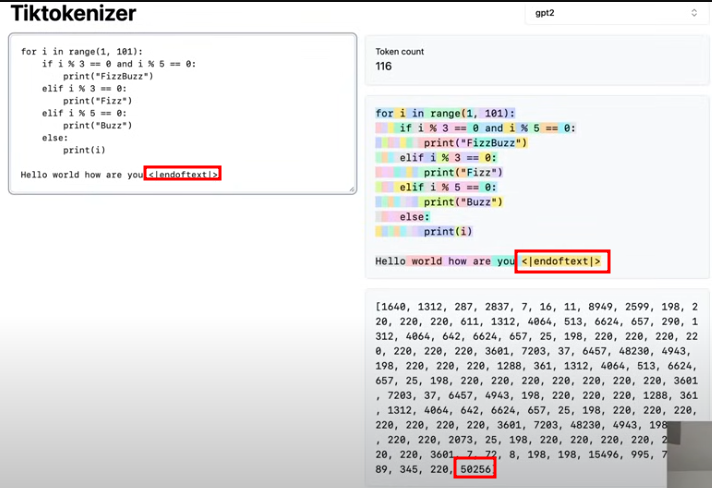

## for GPT4
```
    special_tokens = {
        ENDOFTEXT: 100257,
        FIM_PREFIX: 100258,
        FIM_MIDDLE: 100259,
        FIM_SUFFIX: 100260,
        ENDOFPROMPT: 100276,
    }
```
[Note] FIM = Fill In the Middle : search paper "Effcient Training of Language Models to Fill in the Middle"

you can extend your tokens list, also make sure you need to modify your model to be able to recongnize and output that new tokens.
 

# sentencepiece library intro, used to train Llama 2 vocabulary

Commonly used because (unlike tiktoken) it can eficiently both train and inference BPE tokenizers, It is used in both Llama and Mistral series
https://github.com/google/sentencepiece

The big diference: sentencepiece runs BPE on the Unicode (code points) directly! it then has an option character_coverage for what to do with very rare codepoints that appear very few times, and it either maps them onto an UNK token, or if byte_fallback is tured on, it encodes them with utf-8 and then encodes the raw bytes instead
TLDR:
* tiktoken encodes to utf-8 and then BPEs bytes
* sentencepiece BPEs the code points and optionally fals back to utf-8 bytes for rare code points (rarity is determined by character_coverage hyperparameter), which then get translated to byte tokens

## 对比 tiktoken vs SentencePiece
| **特性**               | **SentencePiece**                          | **tiktoken**                          |
|------------------------|--------------------------------------------|---------------------------------------|
| **输入**               | 直接对 Unicode 码点(codepoint) 运行 BPE        | 先将文本转换为 UTF-8 字节，再运行 BPE |
| **罕见字符处理**       | 使用 `character_coverage` 和 `byte_fallback` | 直接对字节运行 BPE，无需额外处理      |
| **灵活性**             | 更灵活，可以处理多种语言和罕见字符         | 更高效，适合大规模文本处理            |
| **适用场景**           | 多语言模型、需要处理罕见字符的场景         | 英文为主的模型、大规模预训练模型      |

SentencePiece 的工作方式是从 Unicode 码点（Code Point） 开始处理的，因此它实际上是在 字符级别（character level） 进行操作，而不是在 字节级别（byte level）, like tiktoken.

## Unicode 码点（Code Point）
定义:

Unicode 码点是 Unicode 标准中为每个字符分配的唯一数字标识。

它是一个抽象的编号，范围从 U+0000 到 U+10FFFF（共 1,114,112 个可能的码点）。

例如：

* A 的码点是 U+0041。

* 𠜎 的码点是 U+2070E。

特点:

* 码点是字符的逻辑表示，与具体的存储或编码方式无关。

* 码点通常用十六进制表示，前缀为 U+。

## 罕见字符也有 Unicode 码点，为什么不能直接处理？
(1) 罕见字符的出现频率低
在训练数据中，某些 Unicode 字符（如罕见的中文字符、特殊符号等）出现的频率非常低。

如果直接将这些罕见字符加入词汇表，可能会导致以下问题：

词汇表膨胀：词汇表中会包含大量极少使用的字符，增加了模型的大小和计算成本。

过拟合：由于罕见字符的出现次数太少，模型可能无法很好地学习它们的表示。

(2) 多语言支持的挑战
SentencePiece 通常用于多语言场景，而不同语言的字符分布差异很大。

某些语言的字符（如汉字、韩文字符）可能在某些数据集中非常罕见。

如果不处理这些罕见字符，模型可能无法正确处理这些语言的文本。

(3) 兼容性和鲁棒性
在实际应用中，模型可能会遇到训练数据中未出现过的字符（OOV，Out-of-Vocabulary）。

通过特殊处理罕见字符，SentencePiece 可以提高模型的鲁棒性，避免因未知字符而崩溃。

In [22]:
# write a toy.txt file with some random text
with open("toy.txt","w", encoding="utf-8") as f:
    f.write(text)

#! cat toy.txt

In [23]:
# train a sentencepiece model on above "toy.txt"

# the settings here are (best effort) those used for training Llama 2 
import os
import sentencepiece as spm

options = dict(
    #input spec 
    input="toy.txt",
    input_format="text", 
    # output spec
    model_prefix="tok400", # output filename prefix 
    # algorithm spec
    # BPE alg
    model_type="bpe",
    vocab_size=400, 
    #normalization
    normalization_rule_name="identity", # ew, turn off normalization 
    remove_extra_whitespaces=False,
    input_sentence_size=200000000, # max number of training sentences 
    max_sentence_length=4192, # max number of bytes per sentence seed sentencepiece size=1000000,
    shuffle_input_sentence=True, 
    # rare word treatment
    #character_coverage=0.99995, 
    character_coverage=0.995, 
    byte_fallback=False,
    # merge rules 
    split_digits=True,
    split_by_unicode_script=True, 
    split_by_whitespace=True, 
    split_by_number=True,
    max_sentencepiece_length=16,
    add_dummy_prefix=True,
    allow_whitespace_only_pieces=True,
    # special tokens
    unk_id=0, #the UNK token MUST exist
    bos_id=1, # the others are optional, set to -1 to turn off
    eos_id=2,
    pad_id=-1,
    # systems
    num_threads=os.cpu_count(),# use ~all system resources
)
spm.SentencePieceTrainer.train(**options)


sentencepiece_trainer.cc(78) LOG(INFO) Starts training with : 
trainer_spec {
  input: toy.txt
  input_format: text
  model_prefix: tok400
  model_type: BPE
  vocab_size: 400
  self_test_sample_size: 0
  character_coverage: 0.995
  input_sentence_size: 200000000
  shuffle_input_sentence: 1
  seed_sentencepiece_size: 1000000
  shrinking_factor: 0.75
  max_sentence_length: 4192
  num_threads: 12
  num_sub_iterations: 2
  max_sentencepiece_length: 16
  split_by_unicode_script: 1
  split_by_number: 1
  split_by_whitespace: 1
  split_digits: 1
  pretokenization_delimiter: 
  treat_whitespace_as_suffix: 0
  allow_whitespace_only_pieces: 1
  required_chars: 
  byte_fallback: 0
  vocabulary_output_piece_score: 1
  train_extremely_large_corpus: 0
  seed_sentencepieces_file: 
  hard_vocab_limit: 1
  use_all_vocab: 0
  unk_id: 0
  bos_id: 1
  eos_id: 2
  pad_id: -1
  unk_piece: <unk>
  bos_piece: <s>
  eos_piece: </s>
  pad_piece: <pad>
  unk_surface:  ⁇ 
  enable_differential_privacy: 0
  differ

In [24]:
sp = spm.SentencePieceProcessor()
sp.load('tok400.model')
vocab =[[sp.id_to_piece(idx),idx] for idx in range(sp.get_piece_size())]
# vocab

[['<unk>', 0],
 ['<s>', 1],
 ['</s>', 2],
 ['in', 3],
 ['▁t', 4],
 ['▁a', 5],
 ['er', 6],
 ['co', 7],
 ['▁th', 8],
 ['▁s', 9],
 ['▁o', 10],
 ['de', 11],
 ['re', 12],
 ['it', 13],
 ['▁co', 14],
 ['▁the', 15],
 ['ing', 16],
 ['en', 17],
 ['▁p', 18],
 ['at', 19],
 ['an', 20],
 ['or', 21],
 ['le', 22],
 ['▁U', 23],
 ['▁w', 24],
 ['▁in', 25],
 ['ar', 26],
 ['▁b', 27],
 ['es', 28],
 ['ac', 29],
 ['▁of', 30],
 ['on', 31],
 ['al', 32],
 ['▁m', 33],
 ['▁f', 34],
 ['ed', 35],
 ['is', 36],
 ['▁c', 37],
 ['nd', 38],
 ['▁to', 39],
 ['ts', 40],
 ['ic', 41],
 ['ter', 42],
 ['xx', 43],
 ['▁code', 44],
 ['▁po', 45],
 ['▁d', 46],
 ['ou', 47],
 ['▁e', 48],
 ['mp', 49],
 ['ly', 50],
 ['▁“', 51],
 ['ion', 52],
 ['▁poin', 53],
 ['code', 54],
 ['▁and', 55],
 ['▁l', 56],
 ['ni', 57],
 ['us', 58],
 ['nicode', 59],
 ['▁st', 60],
 ['▁Unicode', 61],
 ['as', 62],
 ['ll', 63],
 ['ow', 64],
 ['▁as', 65],
 ['▁n', 66],
 ['▁for', 67],
 ['th', 68],
 ['yy', 69],
 ['ver', 70],
 ['▁points', 71],
 ['ro', 72],
 ['▁T', 73],
 

In [25]:
# toggle byte_fallback=True|False to check difference

ids = sp.encode("hello world! 你好，世界!")
print(ids)
# byte_fallback=True
# [260, 272, 261, 270, 270, 263, 260, 281, 263, 268, 270, 271, 349, 260, 231, 192, 163, 232, 168, 192, 242, 191, 143, 231, 187, 153, 234, 152, 143, 349]
# byte_fallback=False
# [74, 261, 63, 263, 178, 202, 349, 260, 0, 349]

[74, 261, 63, 263, 178, 202, 349, 260, 0, 349]


# how to set vocabulary set? revisiting gpt.py transformer

vocab_size
Q: what should be vocab size?
Q: how can I increase vocab size?
A: let's see. Reminder: gpt.py from nanogpt project

```
import torch.nn as nn

class GpTLanguageModel(nn.Module):
    def __init__(self, vocab_size, n_embd, block_size, n_head, n_layer):
        super().__init__()
        
        # Token embedding table
        self.token_embedding_table = nn.Embedding(vocab_size, n_embd) 
        
        # Position embedding table
        self.position_embedding_table = nn.Embedding(block_size, n_embd)
        
        # Transformer blocks
        self.blocks = nn.Sequential(*[Block(n_embd, n_head=n_head) for _ in range(n_layer)])
        
        # Final layer norm
        self.ln_f = nn.LayerNorm(n_embd)
        
        # Language model head
        self.lm_head = nn.Linear(n_embd, vocab_size)

```
Check this piece of code `self.token_embedding_table = nn.Embedding(vocab_size, n_embd) `, an embedding table with vocab_size X n_embd is created, vocab_size is the number of token (row of table), n_embd is each token's dimmension (collum of table), also the num of channle of Transfomder.

Check this piece of code: `self.lm_head = nn.Linear(n_embd, vocab_size)`, this is the last layer that defines the output of the llm, that each output must be in the token list.

# Learning to Compress Prompts with Gist Tokens
Search this paper "Learning to Compress Prompts with Gist Tokens"

是一种通过提取关键信息来压缩提示（prompts）的方法，旨在用更简洁的表达传递核心内容。其核心理念是：

1. 提取核心信息：从复杂的提示中提取最重要的部分，忽略冗余细节。

2. 使用“Gist Tokens”：用简短的符号或关键词（即“Gist Tokens”）代表核心思想，从而减少输入长度。

3. 提高效率：通过压缩提示，减少计算资源消耗，同时保持模型的理解能力。

这种方法在自然语言处理（NLP）中尤其有用，可以帮助模型更高效地处理长文本或复杂指令，同时保持准确性。

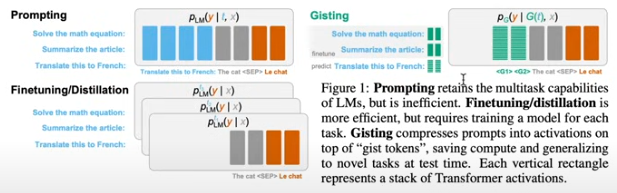

# multimodal [image, video, audio] tokenization with vector quantization
ref https://arxiv.org/abs/2012.09841


# What is the SolidGoldMagikarp problem?

SolidGoldMagikarp is a famous reddit user id, who may has a lot of post on redit. The contents of Reddit post may be used for token generating training, in which "SolidGoldMagikarp" was used often so one dedicate token was generated. But this token is never appear in Training process and has never been "sampled and weighted" during the training process. Therefore some issue will happen when it is been used in intereference undefined behavior


# reinforcement learning from human feedback (RLHF)
* human feedback is much less efficient
* Reinforcement Learning in un-verifiable domains=>RLHF(Reinforcement Learning from Human Feedback)

Naive approach: 
* Run RL as usual, of 1,000 updates of 1,000 prompts of 1.000 rollouts.(cost: 1,000,000,000 scores from humans)

RLHF approach:
STEP 1: Take 1,000 prompts, get 5 rollouts, order them from best to worst(cost: 5,000 scores from humans)
STEP 2: Train a neural net simulator of human preferences ("reward model"), by using STEP1 Output, try best to match the human behavior.
STEP 3: Run RL as usual, but using the simulator instead of actual humans

## RLHF upside
We can run RL, in arbitrary domains! (even the unverifiable ones)
This (empirically) improves the performance of the model, possibly due to the "discriminator - generator gap":
In many cases, it is much easier to discriminate than to generate.
e.g."Write a poem" vs."Which of these 5 poems is best?

RLHF（Reinforcement Learning with Human Feedback）：
这是一种通过人类反馈来优化模型的强化学习方法。模型通过人类的评价或选择来学习如何生成更好的输出。

RL in arbitrary domains：
强化学习可以应用于各种领域，甚至是那些难以验证或评估的领域（例如艺术创作、主观评价等）。

Discriminator-Generator Gap：
这是一个关键概念，指的是“判别任务”比“生成任务”更容易。例如：

生成任务：写一首诗（需要创造力、语言能力等）。

判别任务：从五首诗中选出最好的一首（只需要比较和判断）。
人类或模型在判别任务上表现更好，因此通过强化学习利用这种差距可以提高生成任务的表现。

Empirical improvement：
实际经验表明，RLHF 能够提升模型性能，尤其是在生成任务中。通过让模型学习人类的偏好或判别标准，生成的内容会更符合人类期望。

总结：RLHF 的优势在于它能够利用判别任务的易操作性来优化生成任务，从而在广泛领域中提升模型的表现。

## RLHF downside
We are doing RL with respect to a lossy simulation of humans. it mightbe misleading!
Even more subtle:
RL discovers ways to "game" the model.

E.g. after 1,000 updates, the top joke about pelicans is not the bangeryou want, but something totally non-sensical like "the the the the thethe the the".